In [166]:
# Basic Imports
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Preprocessing
from sklearn import preprocessing
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold, RandomizedSearchCV
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, OrdinalEncoder, MultiLabelBinarizer
from sklearn.utils import resample

# New for Balancing
#%pip install imbalanced-learn
from imblearn.over_sampling import SMOTE
from collections import Counter

# New for Feature Selection
from sklearn.feature_selection import SequentialFeatureSelector

# Feature Importance
%pip install shap
import shap
shap.initjs()

# Classifiers
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.ensemble import RandomForestClassifier

# New classifier
#%pip install xgboost
from xgboost import XGBClassifier

# Evaluation
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import cross_validate


#Ignore Warnings
import warnings
warnings.filterwarnings("ignore")

Note: you may need to restart the kernel to use updated packages.


## research questions: 
1. How well does machine learning predict children’s happiness based on mobile phone usage and the level of attention in Burkina Faso?
2. What is the relationship between mobile phone usage and children’s attention levels in a context of how long they have had a mobile phone?

## Load data

In [167]:
df = pd.read_csv('BF_ML_ready.csv')

print(f"Dataset shape: {df.shape}")
df.head()

Dataset shape: (672, 55)


,ID,Age,Class,Sex_binary,Attention_Score,Happiness_Score,PhoneUse_Score,A1,A2,A3,...,T12,T13,T14,school every day,share phone family,electricity at home,parents rules phone,Phone purpose,Phone_total_months,Has_phone
0,1,15,10,1,2.266667,3.166667,4.583333,1,4,1,...,4,0.0,4.0,0,0,1,0,Communication,4.0,1.0
1,2,14,10,0,3.000000,3.583333,4.250000,1,4,4,...,4,1.0,0.0,0,0,0,0,"School, Games",12.0,1.0
2,3,14,10,1,1.333333,3.000000,1.083333,1,1,1,...,1,0.0,0.0,0,0,0,0,Communication,0.0,0.0
3,4,15,10,1,2.000000,2.916667,3.916667,1,1,4,...,3,1.0,0.0,0,1,0,0,School,12.0,1.0
4,5,16,10,0,2.066667,2.666667,3.833333,3,3,1,...,2,16.0,0.0,0,0,1,0,Communication,192.0,1.0


## Data Preprocessing

In [168]:
# Drop individual happiness items, keeping only the average score
happiness_items = ['ID', 'H1', 'H2', 'H3', 'H4', 'H5', 'H6', 'H7', 'H8', 'H9', 'H10', 'H11', 'H12', 'T13', 'T14']
df.drop(columns=happiness_items, inplace=True, errors='ignore')

print(f"Dataset shape after dropping columns: {df.shape}")
df.head()

Dataset shape after dropping columns: (672, 40)


,Age,Class,Sex_binary,Attention_Score,Happiness_Score,PhoneUse_Score,A1,A2,A3,A4,...,T10,T11,T12,school every day,share phone family,electricity at home,parents rules phone,Phone purpose,Phone_total_months,Has_phone
0,15,10,1,2.266667,3.166667,4.583333,1,4,1,1,...,3,5,4,0,0,1,0,Communication,4.0,1.0
1,14,10,0,3.000000,3.583333,4.250000,1,4,4,3,...,3,4,4,0,0,0,0,"School, Games",12.0,1.0
2,14,10,1,1.333333,3.000000,1.083333,1,1,1,1,...,1,1,1,0,0,0,0,Communication,0.0,0.0
3,15,10,1,2.000000,2.916667,3.916667,1,1,4,1,...,2,5,3,0,1,0,0,School,12.0,1.0
4,16,10,0,2.066667,2.666667,3.833333,3,3,1,2,...,3,5,2,0,0,1,0,Communication,192.0,1.0


In [169]:
# Convert Happiness_Score into binary classification (0: Low, 1: High)
df['Happiness_Level'] = pd.cut(
    df['Happiness_Score'],
    bins=[0.00, 2.90, 4.00],
    labels=[0, 1],
    include_lowest=True,
    right=True
).astype(int)

# Drop the continuous score
df.drop(columns=['Happiness_Score'], inplace=True)

print("Target variable distribution:")
print(df['Happiness_Level'].value_counts())
print(f"\nProportions:")
print(df['Happiness_Level'].value_counts(normalize=True))

Target variable distribution:
Happiness_Level
0    391
1    281
Name: count, dtype: int64

Proportions:
Happiness_Level
0    0.581845
1    0.418155
Name: proportion, dtype: float64


In [170]:
# Process 'phone purpose' multi-label column
PREFIX = "phone purpose: "
base_labels = ["School", "Communication", "Games", "Social Media", "Music"]
phone_cols = [f"{PREFIX}{c}" for c in base_labels]
other_col = f"{PREFIX}Other"

# Mapping variants to standard labels
variant_map = {
    "school": "School", "study": "School", "education": "School",
    "communication": "Communication", "call": "Communication", "calls": "Communication",
    "chat": "Communication", "messaging": "Communication", "texting": "Communication",
    "sms": "Communication", "email": "Communication",
    "game": "Games", "games": "Games", "gaming": "Games",
    "social media": "Social Media", "social": "Social Media", "facebook": "Social Media",
    "instagram": "Social Media", "twitter": "Social Media", "snapchat": "Social Media",
    "music": "Music", "songs": "Music", "audio": "Music", "spotify": "Music"
}

def normalize_and_split(raw_text):
    """Normalize and split multi-label phone purpose text."""
    if pd.isna(raw_text):
        return []
    text = str(raw_text).lower().strip()
    parts = [p.strip() for p in text.replace(',', ' ').replace(';', ' ').split()]
    return [variant_map.get(p, p.title()) for p in parts if p]

# Initialize binary columns
for col in phone_cols + [other_col]:
    df[col] = 0

# Process each row
for idx, val in df['Phone purpose'].items():
    labels = normalize_and_split(val)
    for label in labels:
        col_name = f"{PREFIX}{label}"
        if col_name in phone_cols:
            df.at[idx, col_name] = 1
        elif label not in base_labels:
            df.at[idx, other_col] = 1

# Drop original column
df.drop(columns=['Phone purpose'], inplace=True)

print("Phone purpose encoded successfully!")
print(f"\nEncoded columns: {phone_cols + [other_col]}")
df

Phone purpose encoded successfully!

Encoded columns: ['phone purpose: School', 'phone purpose: Communication', 'phone purpose: Games', 'phone purpose: Social Media', 'phone purpose: Music', 'phone purpose: Other']


,Age,Class,Sex_binary,Attention_Score,PhoneUse_Score,A1,A2,A3,A4,A5,...,parents rules phone,Phone_total_months,Has_phone,Happiness_Level,phone purpose: School,phone purpose: Communication,phone purpose: Games,phone purpose: Social Media,phone purpose: Music,phone purpose: Other
0,15,10,1,2.266667,4.583333,1,4,1,1,3,...,0,4.0,1.0,1,0,1,0,0,0,0
1,14,10,0,3.000000,4.250000,1,4,4,3,4,...,0,12.0,1.0,1,1,0,1,0,0,0
2,14,10,1,1.333333,1.083333,1,1,1,1,1,...,0,0.0,0.0,1,0,1,0,0,0,0
3,15,10,1,2.000000,3.916667,1,1,4,1,3,...,0,12.0,1.0,1,1,0,0,0,0,0
4,16,10,0,2.066667,3.833333,3,3,1,2,1,...,0,192.0,1.0,0,0,1,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
667,22,13,1,1.333333,3.166667,1,1,1,1,2,...,0,12.0,1.0,0,0,1,0,0,0,0
668,18,13,1,1.733333,3.583333,1,1,1,1,4,...,0,72.0,1.0,0,0,0,0,0,1,0
669,20,13,1,2.333333,3.500000,1,2,1,1,3,...,0,42.0,1.0,0,0,1,0,0,0,0
670,20,13,1,2.000000,2.250000,1,4,1,1,1,...,0,1.0,1.0,0,1,0,0,0,0,0


## Train test splitting

In [171]:
# Separate features and target
y = df['Happiness_Level']
X = df.drop(columns='Happiness_Level')

# Perform stratified split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print(f"Training set size: {X_train.shape}")
print(f"Test set size: {X_test.shape}")
print(f"\nTarget distribution in training set:")
print(y_train.value_counts(normalize=True))

Training set size: (537, 44)
Test set size: (135, 44)

Target distribution in training set:
Happiness_Level
0    0.581006
1    0.418994
Name: proportion, dtype: float64


In [172]:
# Check for missing values
print("Missing values in training set:")
print(X_train.isnull().sum()[X_train.isnull().sum() > 0])

print("\nMissing values in test set:")
print(X_test.isnull().sum()[X_test.isnull().sum() > 0])

# Handle missing values - fill with median for numeric columns
for col in X_train.columns:
    if X_train[col].isnull().any():
        median_value = X_train[col].median()
        X_train[col].fillna(median_value, inplace=True)
        X_test[col].fillna(median_value, inplace=True)

# Verify no missing values remain
print(f"\nMissing values after cleaning:")
print(f"Training set: {X_train.isnull().sum().sum()}")
print(f"Test set: {X_test.isnull().sum().sum()}")
print("\nData cleaning complete!")

Missing values in training set:
Phone_total_months    4
dtype: int64

Missing values in test set:
Phone_total_months    2
dtype: int64

Missing values after cleaning:
Training set: 0
Test set: 0

Data cleaning complete!


## Correlation matrix

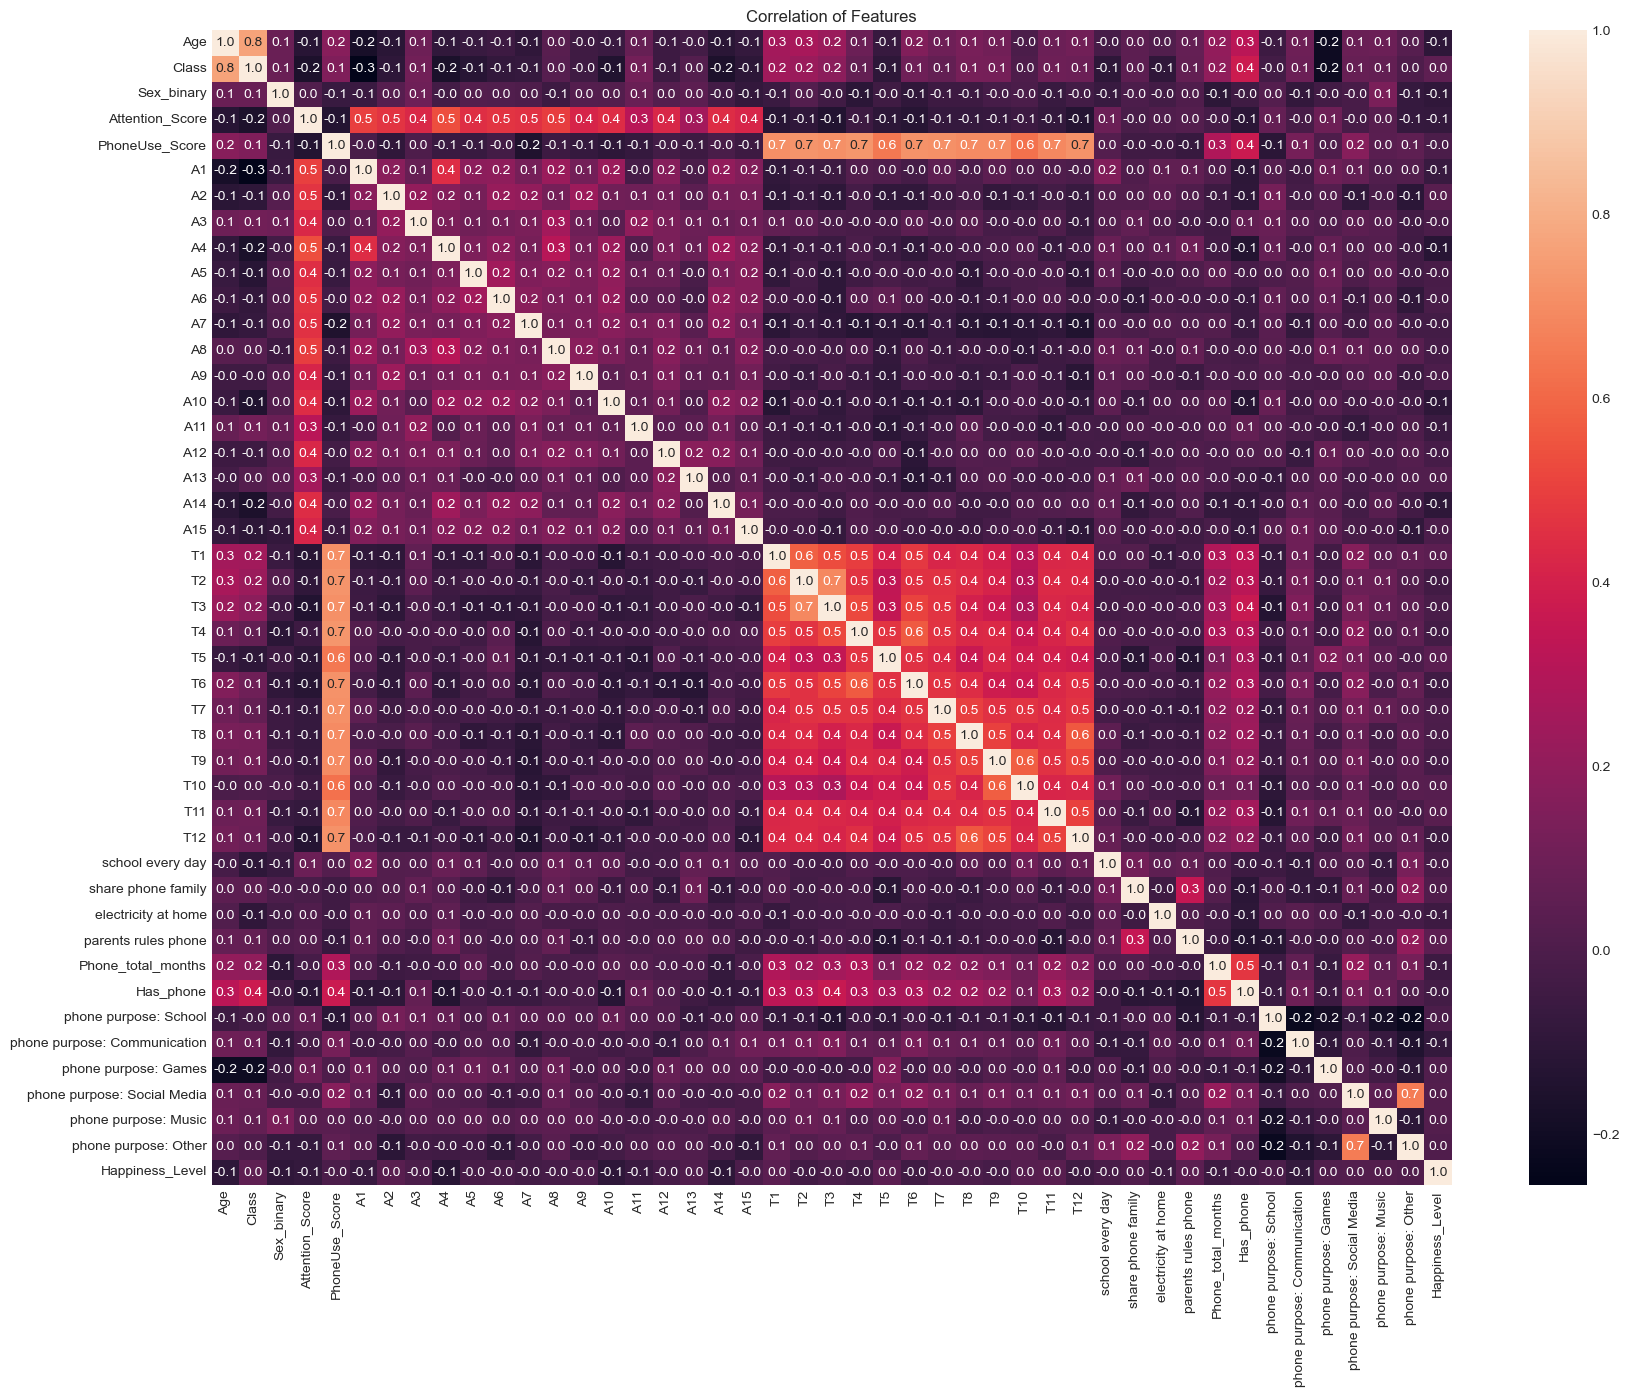


Top 10 features by correlation with target:
A4                              0.119063
A10                             0.102113
Age                             0.100362
A14                             0.099854
Sex_binary                      0.097295
phone purpose: Communication    0.081824
Attention_Score                 0.081631
A1                              0.068564
A11                             0.061012
electricity at home             0.051683
Name: Happiness_Level, dtype: float64


In [173]:
# Combine training features and target for correlation analysis
df_train = pd.concat([X_train, y_train.rename('Happiness_Level')], axis=1)

# Calculate correlation matrix
correlation_matrix = df_train.corr(numeric_only=True)

# 2) Correlation heatmap (optional)
plt.figure(figsize=(20, 15))
correlation_matrix = df_train.corr(numeric_only=True)
sns.heatmap(correlation_matrix, annot=True, fmt=".1f")
plt.title('Correlation of Features')
plt.show()

# Rank features by correlation with target
corr_with_target = correlation_matrix['Happiness_Level'].drop('Happiness_Level').abs().sort_values(ascending=False)
print("\nTop 10 features by correlation with target:")
print(corr_with_target.head(10))

In [174]:
# Use all available features (no feature selection)
X_train_sel = X_train.copy()
X_test_sel = X_test.copy()
selected_features = X_train.columns.tolist()

print(f"Using all {len(selected_features)} features:")
print(f"Training set shape: {X_train_sel.shape}")
print(f"Test set shape: {X_test_sel.shape}")

Using all 44 features:
Training set shape: (537, 44)
Test set shape: (135, 44)


## Model training 

In [175]:
# Train and evaluate baseline models
models = {
    'Decision Tree': DecisionTreeClassifier(random_state=42),
    'Random Forest': RandomForestClassifier(random_state=42),
    'XGBoost': XGBClassifier(random_state=42, eval_metric='logloss')
}

results = []

for name, model in models.items():
    # Train model
    model.fit(X_train_sel, y_train)
    
    # Make predictions
    y_pred = model.predict(X_test_sel)
    
    # Calculate metrics
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred, zero_division=0)
    recall = recall_score(y_test, y_pred, zero_division=0)
    f1 = f1_score(y_test, y_pred, zero_division=0)
    
    results.append({
        'Model': name,
        'Accuracy': accuracy,
        'Precision': precision,
        'Recall': recall,
        'F1 Score': f1
    })
    
    print(f"\n{'='*60}")
    print(f"{name}")
    print(f"{'='*60}")
    print(f"Accuracy:  {accuracy:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall:    {recall:.4f}")
    print(f"F1 Score:  {f1:.4f}")

# Create results dataframe
results_df = pd.DataFrame(results).sort_values('F1 Score', ascending=False)
print(f"\n{'='*60}")
print("Model Comparison (sorted by F1 Score)")
print(f"{'='*60}")
print(results_df.to_string(index=False))


Decision Tree
Accuracy:  0.5037
Precision: 0.4127
Recall:    0.4643
F1 Score:  0.4370

Random Forest
Accuracy:  0.6370
Precision: 0.6296
Recall:    0.3036
F1 Score:  0.4096

XGBoost
Accuracy:  0.6000
Precision: 0.5200
Recall:    0.4643
F1 Score:  0.4906

Model Comparison (sorted by F1 Score)
        Model  Accuracy  Precision   Recall  F1 Score
      XGBoost  0.600000   0.520000 0.464286  0.490566
Decision Tree  0.503704   0.412698 0.464286  0.436975
Random Forest  0.637037   0.629630 0.303571  0.409639


## Hyperparameter tuning

In [176]:
# Hyperparameter tuning for Random Forest using RandomizedSearchCV
print("Performing hyperparameter tuning for Random Forest...")

# Define parameter grid
rf_param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [5, 10, 20, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['sqrt', 'log2', None],
}

# Initialize model and cross-validation
rf = RandomForestClassifier(random_state=42)
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Perform randomized search
rf_search = RandomizedSearchCV(
    estimator=rf,
    param_distributions=rf_param_grid,
    n_iter=20,
    scoring='f1',
    cv=cv,
    random_state=42,
    n_jobs=-1,
    verbose=1
)

rf_search.fit(X_train_sel, y_train)

# Get best model
best_rf = rf_search.best_estimator_

print(f"\nBest parameters: {rf_search.best_params_}")
print(f"Best cross-validation F1 score: {rf_search.best_score_:.4f}")

# Evaluate on test set
y_pred_rf = best_rf.predict(X_test_sel)

print(f"\nTest Set Performance:")
print(f"Accuracy:  {accuracy_score(y_test, y_pred_rf):.4f}")
print(f"Precision: {precision_score(y_test, y_pred_rf):.4f}")
print(f"Recall:    {recall_score(y_test, y_pred_rf):.4f}")
print(f"F1 Score:  {f1_score(y_test, y_pred_rf):.4f}")


Performing hyperparameter tuning for Random Forest...
Fitting 5 folds for each of 20 candidates, totalling 100 fits

Best parameters: {'n_estimators': 100, 'min_samples_split': 2, 'min_samples_leaf': 2, 'max_features': None, 'max_depth': 10}
Best cross-validation F1 score: 0.3346

Test Set Performance:
Accuracy:  0.6296
Precision: 0.5833
Recall:    0.3750
F1 Score:  0.4565


## Confusion Matrix


=== Random Forest (tuned) ===
Best parameters: {'n_estimators': 100, 'min_samples_split': 2, 'min_samples_leaf': 2, 'max_features': None, 'max_depth': 10}
Best CV F1: 0.3346
Accuracy: 0.6296296296296297
Precision: 0.5833333333333334
Recall: 0.375
F1: 0.45652173913043476


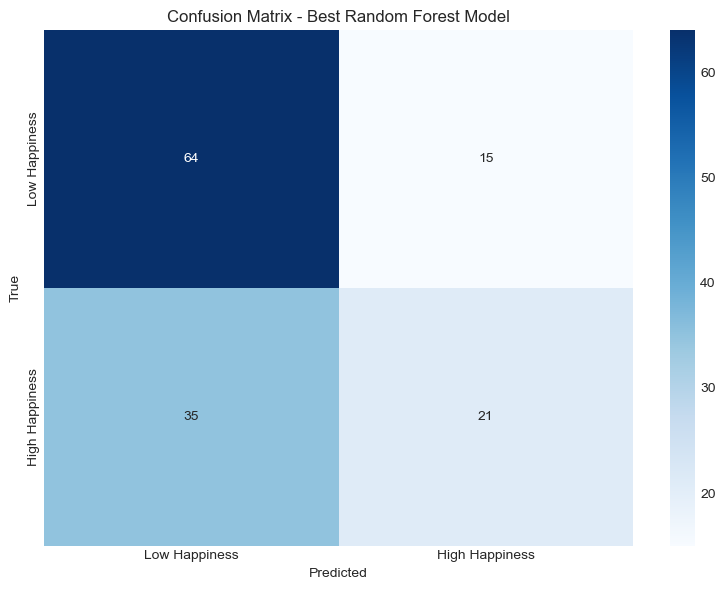


Confusion Matrix:
[[64 15]
 [35 21]]


Exception ignored in: <function ResourceTracker.__del__ at 0x1052cb380>
Traceback (most recent call last):
  File "/opt/homebrew/anaconda3/lib/python3.13/multiprocessing/resource_tracker.py", line 82, in __del__
  File "/opt/homebrew/anaconda3/lib/python3.13/multiprocessing/resource_tracker.py", line 91, in _stop
  File "/opt/homebrew/anaconda3/lib/python3.13/multiprocessing/resource_tracker.py", line 116, in _stop_locked
ChildProcessError: [Errno 10] No child processes
Exception ignored in: <function ResourceTracker.__del__ at 0x1068b7380>
Traceback (most recent call last):
  File "/opt/homebrew/anaconda3/lib/python3.13/multiprocessing/resource_tracker.py", line 82, in __del__
  File "/opt/homebrew/anaconda3/lib/python3.13/multiprocessing/resource_tracker.py", line 91, in _stop
  File "/opt/homebrew/anaconda3/lib/python3.13/multiprocessing/resource_tracker.py", line 116, in _stop_locked
ChildProcessError: [Errno 10] No child processes
Exception ignored in: <function ResourceTracker.__

In [177]:
# Confusion matrix for best model
cm = confusion_matrix(y_test, y_pred_rf)

print("\n=== Random Forest (tuned) ===")
print("Best parameters:", rf_search.best_params_)
print("Best CV F1:", round(rf_search.best_score_, 4))

print("Accuracy:", accuracy_score(y_test,y_pred_rf))
print("Precision:", precision_score(y_test, y_pred_rf))
print("Recall:", recall_score(y_test, y_pred_rf))
print("F1:", f1_score(y_test, y_pred_rf))

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['Low Happiness', 'High Happiness'],
            yticklabels=['Low Happiness', 'High Happiness'])
plt.ylabel('True')
plt.xlabel('Predicted')
plt.title('Confusion Matrix - Best Random Forest Model')
plt.tight_layout()
plt.show()


print("\nConfusion Matrix:")
print(cm)

## SHAP
